# Assignment 6: Neural Networks


### You will continue work on the Digit Recognition problem in Kaggle.com this week.   As in Assignment 5, we will assess classification performance accuracy and processing time. 
### Python TensorFlow should be used for Assignment 6. (If you experience difficulty installing TensorFlow, Python scikit-learn may be used as an alternative for Assignment 6.)


## benchmark experiment:

Tested neural network structures should be explored within a benchmark experiment, a factorial design with at least two levels on each of two experimental factors (at least a 2x2 completely crossed design). 
But due to the time required to fit each neural network, we will observe only one trial for each cell in the design. You will build your models on train.csv and submit your forecasts for test.csv to Kaggle.com, providing your name and user ID for each experimental trial..

An example experiment could include two values for the number of nodes per inner layer and two values for the number of inner layers. Various machine learning hyperparameter settings may be used.

Students are encouraged to work in study teams on this assignment, with the understanding that each student must run the code himself/herself and write an independent report of the experimental results. 

## Deliverable: 
    In summary, this assignment asks you to fit a number of neural networks, comparing processing time and performance across experimental treatments.
     Processing time will be recorded for the fitting on the train.csv.  Kaggle.com accuracy scores will be reported for all benchmarks.  

# Management Question
    Suppose you are a financial institution evaluating machine learning technologies for optical character recognition. Initial testing is on the MNIST digits.
     What can you conclude from your benchmark study? Which neural network typology and hyperparameter settings would you recommend as being the most trustworthy?

# Discussion

A 3x3 factorial design was conducted using 2, 3 and 5 dense layers and each layer consisting of 10,20, and 40 nodes for a total of 9 models. 
The hyperparameter tuning package ,kerastuner, identified that a slower learning rate (0.001 versus 0.01) was desirable. Adjusting this hyperparameter brings the accuracy of the training and validation sets closer to one another. A summary table of the models is provided below all of the models were able to converge in under 1 minute time. Several line charts are also provided to aid in the presentation of the accuracy and duration require to train the models below as well. It is likely that increase the number of dense layers further and the number of nodes will allow for even higher prediction accuracy of the test set. It's apparent from the training history charts provided in each model section that as we increase the number of layers we will require an increase in the number of nodes to maintain a similar deviation between or test and validation set in terms of accuracy. The increasing of nodes and layers does lead to an increase in the duraction required to conduct the training, but this is likely inconsequential as we are more interesting in making correct predictions/classifications. As such  model 5L40N produced the highest accuracy with the test data, however, further exploration is warranted. Increasing the number of nodes is going to lead to much longer training times. It would be worthwhile to consider adding a dropout fraction after each layer to speed up the training process. Additionaly it may be worthwhile to consider adding dynamic hyperparameters. Three and five layer models which contain 10 nodes seem to dramatically under perform interms of validation versus the training set accuracy; these will need many more epochs to converge, but as is the performance on unseen data for this will suffer.  A preferred alternative would be to simply increase the number of nodes versus the number of epochs, and as mentioned above if time is important there are other methods to consider (dropout and in particular a dynamic learning rate).

## Testing

In [1]:
# import base packages into the namespace for this program
import os
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime

#diplay and plotting
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

import pydot
import graphviz
import getpass
import smtplib

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV





In [2]:
#password block for the sender email. 
try:
   pwd = getpass.getpass()
except Exception as err:
   print('Error Occured : ', err)
else:
   print('Password has been entered and is character length:', len(pwd))

Password has been entered and is character length: 15


In [3]:
# read data for the Boston Housing Study
Digit_input = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/Digits-Train.csv")
Digit_test = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/test.csv")
#sets random seed for entire notebook
RANDOM_SEED = 1

#kfold for CV of models
kfold = KFold(n_splits=5, random_state=RANDOM_SEED)
testkfold = KFold(n_splits=2, random_state=RANDOM_SEED)

In [4]:
Digit_input.label.value_counts().sort_values()

5    3795
8    4063
4    4072
0    4132
6    4137
2    4177
9    4188
3    4351
7    4401
1    4684
Name: label, dtype: int64

## Build our tensorboard log function

In [5]:
logdir = 'C:/Users/bblank/Documents/keras_logfiles'
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join('C:/Users/bblank/Documents/keras_logfiles', run_id)

run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

## Split our data train and validation holdout

In [6]:
#splits into validation and train.
train, val =  train_test_split(Digit_input, test_size = 0.2, random_state = RANDOM_SEED)


y_train = train.label.copy()
X_train = train.drop('label', axis=1)


y_val = val.label.copy()
X_val = val.drop('label', axis=1)

## Quick image EDA

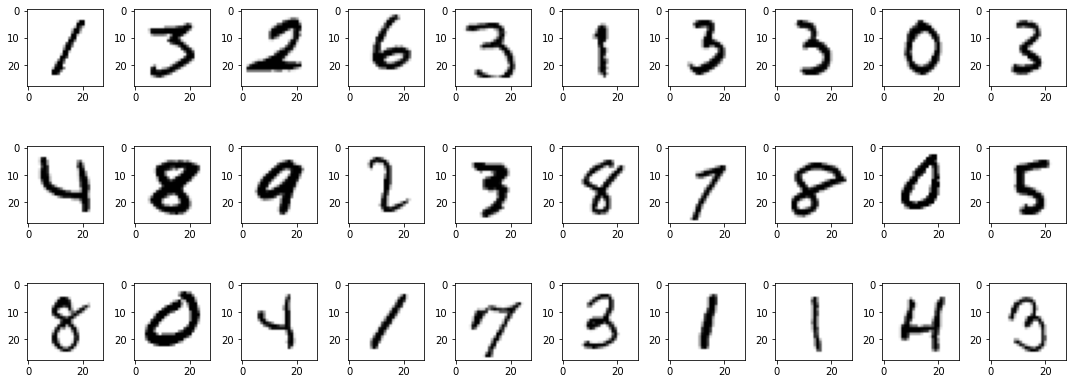

In [7]:
## plots the first 30 digits in 3 rows of 10 images. Data is unscaled
num_row = 3
num_col = 10
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(30):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(X_train.iloc[i]).reshape(28,28), cmap='gist_yarg')
    #ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

## pipeline to ensure scaling is consistent from train to validation

In [8]:
#Scales within pipeline to ensure same scaler.

scale = Pipeline([
        ('scaler', MinMaxScaler())
        ])
        
X_train = scale.fit_transform(X_train)
x_val = scale.fit_transform(X_val)

# Builds and compiles model_2L10N (2 layers; 10 nodes)

In [9]:
opt = keras.optimizers.SGD(learning_rate=0.001)

model_2L10N= keras.models.Sequential()
model_2L10N.add(keras.layers.Flatten(input_shape=[28,28]))
model_2L10N.add(keras.layers.Dense(10, activation ='relu'))
model_2L10N.add(keras.layers.Dense(10, activation ='relu'))
model_2L10N.add(keras.layers.Dense(10, activation ='softmax'))

model_2L10N.summary()
model_2L10N.compile(loss= "sparse_categorical_crossentropy", 
    optimizer = opt, 
    metrics = ['accuracy'])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 8,070
Trainable params: 8,070
Non-trainable params: 0
_________________________________________________________________


## Fits our model 2L10N

In [10]:

start=datetime.now()
#includes log callback for tensorboard.
train_2L10N = model_2L10N.fit(X_train, y_train, epochs=30, validation_data = (X_val, y_val), callbacks = [tensorboard_cb])

after_fit = datetime.now()
elapsed = after_fit-start
train_2L10N_elapsed= elapsed.total_seconds()


Epoch 1/30
1050/1050 [==============================] - 3s 2ms/step - loss: 2.2687 - accuracy: 0.1410 - val_loss: 73.9917 - val_accuracy: 0.2469
Epoch 2/30
1050/1050 [==============================] - 1s 1ms/step - loss: 2.0845 - accuracy: 0.3009 - val_loss: 87.1200 - val_accuracy: 0.2951
Epoch 3/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.8924 - accuracy: 0.3609 - val_loss: 86.8044 - val_accuracy: 0.3575
Epoch 4/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.6622 - accuracy: 0.4830 - val_loss: 67.3919 - val_accuracy: 0.5298
Epoch 5/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.3743 - accuracy: 0.6404 - val_loss: 51.3798 - val_accuracy: 0.6936
Epoch 6/30
1050/1050 [==============================] - 1s 993us/step - loss: 1.0957 - accuracy: 0.7388 - val_loss: 48.9581 - val_accuracy: 0.7577
Epoch 7/30
1050/1050 [==============================] - 1s 974us/step - loss: 0.9086 - accuracy: 0.7737 - val_loss: 50.1166 - va

In [11]:
model_2L10N_accuracy = np.max(train_2L10N.history['accuracy']).round(3)
model_2L10N_val_accuracy = np.max(train_2L10N.history['val_accuracy']).round(3)

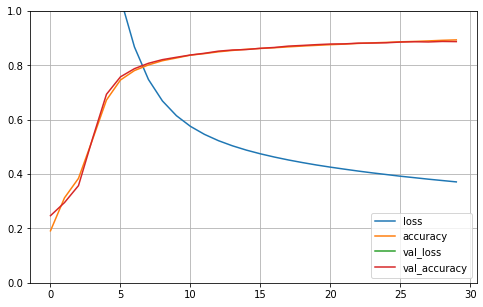

In [12]:
pd.DataFrame(train_2L10N.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# Builds and compiles model_2L20N (2 layers; 20 nodes)

In [13]:

model_2L20N= keras.models.Sequential()
model_2L20N.add(keras.layers.Flatten(input_shape=[28,28]))
model_2L20N.add(keras.layers.Dense(20, activation ='relu'))
model_2L20N.add(keras.layers.Dense(20, activation ='relu'))
model_2L20N.add(keras.layers.Dense(10, activation ='softmax'))

model_2L20N.summary()
model_2L20N.compile(loss= "sparse_categorical_crossentropy", 
    optimizer = opt, 
    metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                15700     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                210       
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
_________________________________________________________________


In [14]:
start=datetime.now()
#includes log callback for tensorboard
train_2L20N = model_2L20N.fit(X_train, y_train, epochs=30,  validation_data = (X_val, y_val), callbacks = [tensorboard_cb])

after_fit = datetime.now()
elapsed = after_fit-start
train_2L20N_elapsed= elapsed.total_seconds()

Epoch 1/30
1050/1050 [==============================] - 2s 2ms/step - loss: 2.2747 - accuracy: 0.1457 - val_loss: 73.0224 - val_accuracy: 0.2950
Epoch 2/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.9499 - accuracy: 0.3630 - val_loss: 70.4107 - val_accuracy: 0.4838
Epoch 3/30
1050/1050 [==============================] - 1s 1000us/step - loss: 1.5498 - accuracy: 0.5672 - val_loss: 55.2922 - val_accuracy: 0.6667
Epoch 4/30
1050/1050 [==============================] - 1s 998us/step - loss: 1.1780 - accuracy: 0.7066 - val_loss: 50.4815 - val_accuracy: 0.7471
Epoch 5/30
1050/1050 [==============================] - 1s 1ms/step - loss: 0.9316 - accuracy: 0.7620 - val_loss: 50.4810 - val_accuracy: 0.7829
Epoch 6/30
1050/1050 [==============================] - 1s 1ms/step - loss: 0.7834 - accuracy: 0.7924 - val_loss: 50.8408 - val_accuracy: 0.8054
Epoch 7/30
1050/1050 [==============================] - 1s 1ms/step - loss: 0.6790 - accuracy: 0.8139 - val_loss: 50.1138 - v

In [15]:
model_2L20N_accuracy = np.max(train_2L20N.history['accuracy']).round(3)
model_2L20N_val_accuracy = np.max(train_2L20N.history['val_accuracy']).round(3)

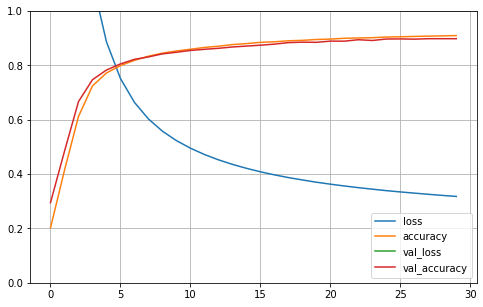

In [16]:
pd.DataFrame(train_2L20N.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# Builds and compiles model_2L40N (2 layers; 40 nodes)

In [17]:

model_2L40N= keras.models.Sequential()
model_2L40N.add(keras.layers.Flatten(input_shape=[28,28]))
model_2L40N.add(keras.layers.Dense(40, activation ='relu'))
model_2L40N.add(keras.layers.Dense(40, activation ='relu'))
model_2L40N.add(keras.layers.Dense(10, activation ='softmax'))

model_2L40N.summary()
model_2L40N.compile(loss= "sparse_categorical_crossentropy", 
    optimizer = opt, 
    metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                31400     
_________________________________________________________________
dense_7 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                410       
Total params: 33,450
Trainable params: 33,450
Non-trainable params: 0
_________________________________________________________________


In [18]:
start=datetime.now()
#includes log callback for tensorboard
train_2L40N = model_2L40N.fit(X_train, y_train, epochs=30,  validation_data = (X_val, y_val), callbacks = [tensorboard_cb])

after_fit = datetime.now()
elapsed = after_fit-start
train_2L40N_elapsed= elapsed.total_seconds()

model_2L40N_accuracy = np.max(train_2L40N.history['accuracy']).round(3)
model_2L40N_val_accuracy = np.max(train_2L40N.history['val_accuracy']).round(3)

Epoch 1/30
1050/1050 [==============================] - 2s 2ms/step - loss: 2.1953 - accuracy: 0.2502 - val_loss: 46.6964 - val_accuracy: 0.5260
Epoch 2/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.7704 - accuracy: 0.5705 - val_loss: 44.9139 - val_accuracy: 0.6757
Epoch 3/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.3171 - accuracy: 0.7015 - val_loss: 41.1054 - val_accuracy: 0.7544
Epoch 4/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.0061 - accuracy: 0.7639 - val_loss: 40.2460 - val_accuracy: 0.8035
Epoch 5/30
1050/1050 [==============================] - 1s 1ms/step - loss: 0.7968 - accuracy: 0.8073 - val_loss: 41.8641 - val_accuracy: 0.8240
Epoch 6/30
1050/1050 [==============================] - 1s 1ms/step - loss: 0.6870 - accuracy: 0.8286 - val_loss: 42.6372 - val_accuracy: 0.8405
Epoch 7/30
1050/1050 [==============================] - 1s 1ms/step - loss: 0.6147 - accuracy: 0.8410 - val_loss: 42.8733 - val_ac

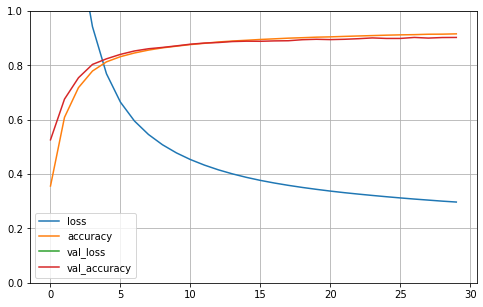

In [19]:
pd.DataFrame(train_2L40N.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# Builds and compiles model_5L10N (5 layers; 10 nodes)

In [20]:
model_5L10N= keras.models.Sequential()
model_5L10N.add(keras.layers.Flatten(input_shape=[28,28]))
model_5L10N.add(keras.layers.Dense(10, activation ='relu'))
model_5L10N.add(keras.layers.Dense(10, activation ='relu'))
model_5L10N.add(keras.layers.Dense(10, activation ='relu'))
model_5L10N.add(keras.layers.Dense(10, activation ='relu'))
model_5L10N.add(keras.layers.Dense(10, activation ='relu'))
model_5L10N.add(keras.layers.Dense(10, activation ='softmax'))

model_5L10N.summary()
model_5L10N.compile(loss= "sparse_categorical_crossentropy", 
    optimizer = opt, 
    metrics = ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_12 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 10)               

In [21]:
start=datetime.now()

train_5L10N = model_5L10N.fit(X_train, y_train, epochs=30, validation_data = (X_val, y_val), callbacks = [tensorboard_cb])

after_fit = datetime.now()
elapsed = after_fit-start
train_5L10N_elapsed= elapsed.total_seconds()

Epoch 1/30
1050/1050 [==============================] - 2s 2ms/step - loss: 2.3023 - accuracy: 0.0989 - val_loss: 35.6177 - val_accuracy: 0.1011
Epoch 2/30
1050/1050 [==============================] - 1s 1ms/step - loss: 2.2828 - accuracy: 0.1291 - val_loss: 46.3819 - val_accuracy: 0.1058
Epoch 3/30
1050/1050 [==============================] - 1s 1ms/step - loss: 2.2522 - accuracy: 0.1794 - val_loss: 66.7648 - val_accuracy: 0.1102
Epoch 4/30
1050/1050 [==============================] - 1s 1ms/step - loss: 2.2007 - accuracy: 0.2256 - val_loss: 87.2812 - val_accuracy: 0.1239
Epoch 5/30
1050/1050 [==============================] - 1s 1ms/step - loss: 2.1325 - accuracy: 0.2666 - val_loss: 97.5534 - val_accuracy: 0.1575
Epoch 6/30
1050/1050 [==============================] - 1s 1ms/step - loss: 2.0589 - accuracy: 0.2788 - val_loss: 99.3422 - val_accuracy: 0.1738
Epoch 7/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.9755 - accuracy: 0.3090 - val_loss: 92.8264 - val_ac

In [22]:
model_5L10N_accuracy = np.max(train_5L10N.history['accuracy']).round(3)
model_5L10N_val_accuracy = np.max(train_5L10N.history['val_accuracy']).round(3)

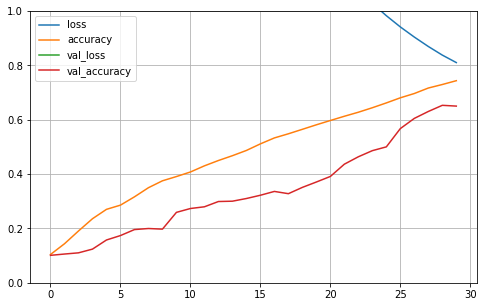

In [23]:
pd.DataFrame(train_5L10N.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# Builds and compiles model_5L20N (5 layers; 20 nodes)

In [24]:
model_5L20N= keras.models.Sequential()
model_5L20N.add(keras.layers.Flatten(input_shape=[28,28]))
model_5L20N.add(keras.layers.Dense(20, activation ='relu'))
model_5L20N.add(keras.layers.Dense(20, activation ='relu'))
model_5L20N.add(keras.layers.Dense(20, activation ='relu'))
model_5L20N.add(keras.layers.Dense(20, activation ='relu'))
model_5L20N.add(keras.layers.Dense(20, activation ='relu'))
model_5L20N.add(keras.layers.Dense(10, activation ='softmax'))

model_5L20N.summary()
model_5L20N.compile(loss= "sparse_categorical_crossentropy", 
    optimizer = opt, 
    metrics = ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                15700     
_________________________________________________________________
dense_16 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_17 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_18 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_19 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_20 (Dense)             (None, 10)               

In [25]:
start=datetime.now()

train_5L20N = model_5L20N.fit(X_train, y_train, epochs=30, validation_data = (X_val, y_val), callbacks = [tensorboard_cb])

after_fit = datetime.now()
elapsed = after_fit-start
train_5L20N_elapsed= elapsed.total_seconds()

Epoch 1/30
1050/1050 [==============================] - 2s 2ms/step - loss: 2.3001 - accuracy: 0.1417 - val_loss: 26.8561 - val_accuracy: 0.1570
Epoch 2/30
1050/1050 [==============================] - 1s 1ms/step - loss: 2.2672 - accuracy: 0.1339 - val_loss: 38.7024 - val_accuracy: 0.1279
Epoch 3/30
1050/1050 [==============================] - 1s 1ms/step - loss: 2.2142 - accuracy: 0.1492 - val_loss: 62.4689 - val_accuracy: 0.1188
Epoch 4/30
1050/1050 [==============================] - 1s 1ms/step - loss: 2.1243 - accuracy: 0.2193 - val_loss: 74.5818 - val_accuracy: 0.1507
Epoch 5/30
1050/1050 [==============================] - 1s 1ms/step - loss: 2.0295 - accuracy: 0.2719 - val_loss: 79.6172 - val_accuracy: 0.2262
Epoch 6/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.9013 - accuracy: 0.3303 - val_loss: 74.7911 - val_accuracy: 0.3694
Epoch 7/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.7088 - accuracy: 0.4194 - val_loss: 81.4420 - val_ac

In [26]:
model_5L20N_accuracy = np.max(train_5L20N.history['accuracy']).round(3)
model_5L20N_val_accuracy = np.max(train_5L20N.history['val_accuracy']).round(3)

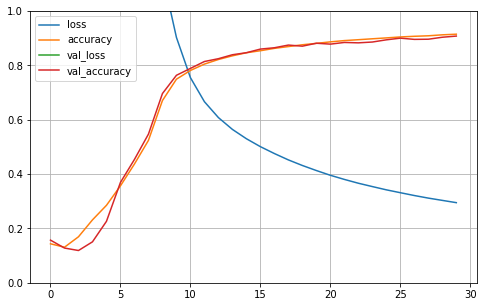

In [27]:
pd.DataFrame(train_5L20N.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# Builds and compiles model_5L40N (5 layers; 40 nodes)

In [28]:
model_5L40N= keras.models.Sequential()
model_5L40N.add(keras.layers.Flatten(input_shape=[28,28]))
model_5L40N.add(keras.layers.Dense(40, activation ='relu'))
model_5L40N.add(keras.layers.Dense(40, activation ='relu'))
model_5L40N.add(keras.layers.Dense(40, activation ='relu'))
model_5L40N.add(keras.layers.Dense(40, activation ='relu'))
model_5L40N.add(keras.layers.Dense(40, activation ='relu'))
model_5L40N.add(keras.layers.Dense(10, activation ='softmax'))

model_5L40N.summary()
model_5L40N.compile(loss= "sparse_categorical_crossentropy", 
    optimizer = opt, 
    metrics = ['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 40)                31400     
_________________________________________________________________
dense_22 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_23 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_24 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_25 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_26 (Dense)             (None, 10)               

In [29]:
start=datetime.now()

train_5L40N = model_5L40N.fit(X_train, y_train, epochs=30, validation_data = (X_val, y_val), callbacks = [tensorboard_cb])

after_fit = datetime.now()
elapsed = after_fit-start
train_5L40N_elapsed= elapsed.total_seconds()
model_5L40N_accuracy = np.max(train_5L40N.history['accuracy']).round(3)
model_5L40N_val_accuracy = np.max(train_5L40N.history['val_accuracy']).round(3)

Epoch 1/30
1050/1050 [==============================] - 3s 2ms/step - loss: 2.2828 - accuracy: 0.1555 - val_loss: 48.4191 - val_accuracy: 0.1667
Epoch 2/30
1050/1050 [==============================] - 1s 1ms/step - loss: 2.1781 - accuracy: 0.2645 - val_loss: 78.5909 - val_accuracy: 0.2245
Epoch 3/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.9742 - accuracy: 0.3414 - val_loss: 86.1736 - val_accuracy: 0.3279
Epoch 4/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.6599 - accuracy: 0.4808 - val_loss: 82.3130 - val_accuracy: 0.5285
Epoch 5/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.3037 - accuracy: 0.5618 - val_loss: 71.8095 - val_accuracy: 0.5992
Epoch 6/30
1050/1050 [==============================] - 1s 1ms/step - loss: 1.0715 - accuracy: 0.6104 - val_loss: 67.0279 - val_accuracy: 0.6731
Epoch 7/30
1050/1050 [==============================] - 1s 1ms/step - loss: 0.9196 - accuracy: 0.6890 - val_loss: 64.9683 - val_ac

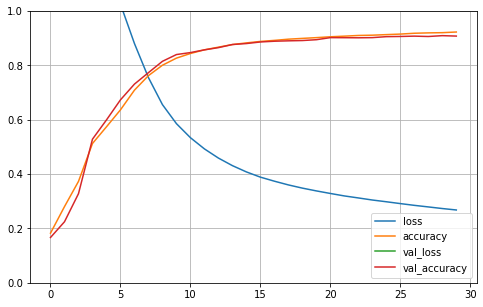

In [30]:
pd.DataFrame(train_5L40N.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# 3 layer models

## Builds, compiles and trains model_3L10N (3 layers; 10 nodes)

In [31]:

model_3L10N= keras.models.Sequential()
model_3L10N.add(keras.layers.Flatten(input_shape=[28,28]))
model_3L10N.add(keras.layers.Dense(10, activation ='relu'))
model_3L10N.add(keras.layers.Dense(10, activation ='relu'))
model_3L10N.add(keras.layers.Dense(10, activation ='relu'))
model_3L10N.add(keras.layers.Dense(10, activation ='softmax'))

model_3L10N.summary()
model_3L10N.compile(loss= "sparse_categorical_crossentropy", 
    optimizer = opt,
    metrics = ['accuracy'])

start=datetime.now()

train_3L10N = model_3L10N.fit(X_train, y_train, epochs=30, validation_data = (X_val, y_val), callbacks = [tensorboard_cb])

after_fit = datetime.now()
elapsed = after_fit-start
train_3L10N_elapsed= elapsed.total_seconds()
model_3L10N_accuracy = np.max(train_3L10N.history['accuracy']).round(3)
model_3L10N_val_accuracy = np.max(train_3L10N.history['val_accuracy']).round(3)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                7850      
_________________________________________________________________
dense_28 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_29 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_30 (Dense)             (None, 10)                110       
Total params: 8,180
Trainable params: 8,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1050/1050 [==============================] - 2s 2ms/step - loss: 2.2751 - accuracy: 0.1212 - val_loss: 48.9

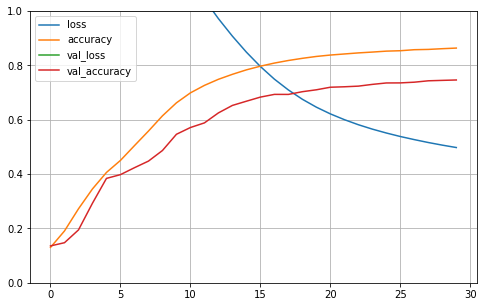

In [32]:
pd.DataFrame(train_3L10N.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## Builds, compiles and trains model_3L20N (3 layers; 20 nodes)

In [33]:
model_3L20N= keras.models.Sequential()
model_3L20N.add(keras.layers.Flatten(input_shape=[28,28]))
model_3L20N.add(keras.layers.Dense(20, activation ='relu'))
model_3L20N.add(keras.layers.Dense(20, activation ='relu'))
model_3L20N.add(keras.layers.Dense(20, activation ='relu'))
model_3L20N.add(keras.layers.Dense(10, activation ='softmax'))

model_3L20N.summary()
model_3L20N.compile(loss= "sparse_categorical_crossentropy", 
    optimizer = opt,
    metrics = ['accuracy'])

start=datetime.now()

train_3L20N = model_3L20N.fit(X_train, y_train, epochs=30, validation_data = (X_val, y_val), callbacks = [tensorboard_cb])

after_fit = datetime.now()
elapsed = after_fit-start
train_3L20N_elapsed= elapsed.total_seconds()
model_3L20N_accuracy = np.max(train_3L20N.history['accuracy']).round(3)
model_3L20N_val_accuracy = np.max(train_3L20N.history['val_accuracy']).round(3)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 20)                15700     
_________________________________________________________________
dense_32 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_33 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_34 (Dense)             (None, 10)                210       
Total params: 16,750
Trainable params: 16,750
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1050/1050 [==============================] - 2s 2ms/step - loss: 2.2921 - accuracy: 0.1303 - val_loss: 28

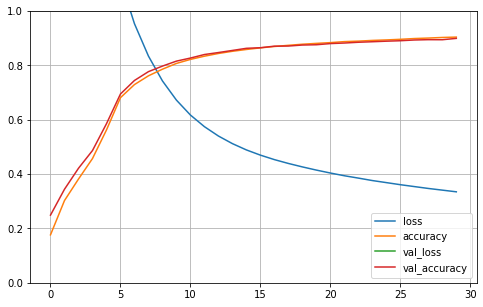

In [34]:
pd.DataFrame(train_3L20N.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## Builds and compiles model_3L40N (3 layers; 40 nodes)## 

In [35]:

model_3L40N= keras.models.Sequential()
model_3L40N.add(keras.layers.Flatten(input_shape=[28,28]))
model_3L40N.add(keras.layers.Dense(40, activation ='relu'))
model_3L40N.add(keras.layers.Dense(40, activation ='relu'))
model_3L40N.add(keras.layers.Dense(40, activation ='relu'))
model_3L40N.add(keras.layers.Dense(10, activation ='softmax'))

model_3L40N.summary()
model_3L40N.compile(loss= "sparse_categorical_crossentropy", 
    optimizer = opt,
    metrics = ['accuracy'])

start=datetime.now()

train_3L40N = model_3L40N.fit(X_train, y_train, epochs=30, validation_data = (X_val, y_val), callbacks = [tensorboard_cb])

after_fit = datetime.now()
elapsed = after_fit-start
train_3L40N_elapsed= elapsed.total_seconds()
model_3L40N_accuracy = np.max(train_3L40N.history['accuracy']).round(3)
model_3L40N_val_accuracy = np.max(train_3L40N.history['val_accuracy']).round(3)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 40)                31400     
_________________________________________________________________
dense_36 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_37 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_38 (Dense)             (None, 10)                410       
Total params: 35,090
Trainable params: 35,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1050/1050 [==============================] - 2s 2ms/step - loss: 2.2486 - accuracy: 0.1472 - val_loss: 46

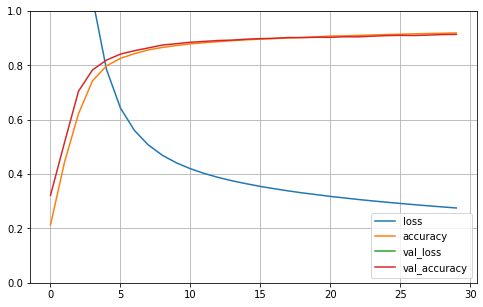

In [36]:
pd.DataFrame(train_3L40N.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [37]:
print(model_2L10N_accuracy)
print(model_2L20N_accuracy)
print(model_2L40N_accuracy)
print(model_5L10N_accuracy)
print(model_5L20N_accuracy)
print(model_5L40N_accuracy)
print(model_3L10N_accuracy)
print(model_3L20N_accuracy)
print(model_3L40N_accuracy)

0.894
0.91
0.916
0.744
0.915
0.923
0.864
0.904
0.919


In [38]:
model_2L10N.history

In [39]:

#email addresses
sender = 'pythonbrianblank@gmail.com'
reciever= 'beblank@gmail.com'


#coerces emails to string; unnecessary if propery formatted
sender = str(sender)
reciever = str(reciever)

sent_from = sender
to = reciever
#email specifics
subject = 'Your Task has completed'
body = 'Your task that was running has completed!\n\n'

email_text = """\
From: %s
To: %s
Subject: %s

%s
""" % (sent_from, ", ".join(to), subject, body)

try:
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.ehlo()
    server.login(sender, pwd)
    server.sendmail(sender, reciever, email_text)
    server.close()

    print ('Email sent!')
except:
    print ('Something went wrong, try again ensuring correct password is used...')

Email sent!


# Predictions

In [40]:
preds_model2L10N = model_2L10N.predict_classes(Digit_test)


In [41]:
ImageId = np.linspace(1,len(preds_model2L10N),len(preds_model2L10N))
labels = pd.DataFrame({"ImageId": ImageId, "Label": preds_model2L10N})
#labels.to_csv('submission_2L10N.csv' ,index=False)
model2L10N_kaggle = 0.86121

In [42]:
preds_model2L20N = model_2L20N.predict_classes(Digit_test)

labels = pd.DataFrame({"ImageId": ImageId, "Label": preds_model2L20N})
#labels.to_csv('submission_2L20N.csv' ,index=False)
model2L20N_kaggle = 0.90692

In [43]:
preds_model2L40N = model_2L40N.predict_classes(Digit_test)

labels = pd.DataFrame({"ImageId": ImageId, "Label": preds_model2L40N})
#labels.to_csv('submission_2L40N.csv' ,index=False)
model2L40N_kaggle = 0.90589

In [44]:
preds_model3L10N = model_3L10N.predict_classes(Digit_test)

labels = pd.DataFrame({"ImageId": ImageId, "Label": preds_model3L10N})
#labels.to_csv('submission_3L10N.csv' ,index=False)
model3L10N_kaggle = 0.86292

In [45]:
preds_model3L20N = model_3L20N.predict_classes(Digit_test)

labels = pd.DataFrame({"ImageId": ImageId, "Label": preds_model3L20N})
#labels.to_csv('submission_3L20N.csv' ,index=False)
model3L20N_kaggle = 0.89653

In [46]:
preds_model3L40N = model_3L40N.predict_classes(Digit_test)

labels = pd.DataFrame({"ImageId": ImageId, "Label": preds_model3L40N})
#labels.to_csv('submission_3L40N.csv' ,index=False)
model3L40N_kaggle = 0.91464

In [47]:
preds_model5L10N = model_5L10N.predict_classes(Digit_test)

labels = pd.DataFrame({"ImageId": ImageId, "Label": preds_model5L10N})
#labels.to_csv('submission_5L10N.csv' ,index=False)
model5L10N_kaggle = 0.85075

In [48]:
preds_model5L20N = model_5L20N.predict_classes(Digit_test)

labels = pd.DataFrame({"ImageId": ImageId, "Label": preds_model5L20N})
#labels.to_csv('submission_5L20N.csv' ,index=False)
model5L20N_kaggle = 0.89760

In [49]:
preds_model5L40N = model_5L40N.predict_classes(Digit_test)

labels = pd.DataFrame({"ImageId": ImageId, "Label": preds_model5L40N})
#labels.to_csv('submission_5L40N.csv' ,index=False)
model5L40N_kaggle =0.93417

# Summary

In [50]:
data3 = {
    'ModelID': ['2L10N', '2L20N', '2L40N', '3L10N', '3L20N', '3L40N', '5L10N', '5L20N', '5L40N'], 
    'layers': [2,2,2,3,3,3,5,5,5],
    'nodes': [10,20,40,10,20,40,10,20,40],    
    'time (seconds)': [train_2L10N_elapsed, train_2L20N_elapsed, train_2L40N_elapsed, train_3L10N_elapsed,
         train_3L20N_elapsed,train_3L40N_elapsed,train_5L10N_elapsed,train_5L20N_elapsed, train_5L40N_elapsed],
    'training accuracy': [model_2L10N_accuracy, model_2L20N_accuracy, model_2L40N_accuracy,
         model_3L10N_accuracy, model_3L20N_accuracy, model_3L40N_accuracy, model_5L10N_accuracy,
         model_5L20N_accuracy, model_5L40N_accuracy],
    'validation accuracy': [model_2L10N_val_accuracy, model_2L20N_val_accuracy, model_2L40N_val_accuracy,
         model_3L10N_val_accuracy, model_3L20N_val_accuracy, model_3L40N_val_accuracy, model_5L10N_val_accuracy,
         model_5L20N_val_accuracy, model_5L40N_val_accuracy],
    'Kaggle Score': [model2L10N_kaggle,model2L20N_kaggle,model2L40N_kaggle, model3L10N_kaggle, model3L20N_kaggle,
        model3L40N_kaggle, model5L10N_kaggle, model5L20N_kaggle, model5L40N_kaggle]
         }
#    'kaggle score:': [Forest_info[1],reduced_Forest_info[1] , recovered_Forest_info[1], val_Forest_info[1], 'NA']}

score2_df = pd.DataFrame.from_dict(data3)

In [51]:
print('\t \t \t ','----------Model Summary Table----------', '\n \n', score2_df.to_string(index=False))


	 	 	  ----------Model Summary Table---------- 
 
 ModelID  layers  nodes  time (seconds)  training accuracy  validation accuracy  Kaggle Score
  2L10N       2     10       35.638575              0.894                0.888       0.86121
  2L20N       2     20       35.145731              0.910                0.898       0.90692
  2L40N       2     40       38.434179              0.916                0.903       0.90589
  3L10N       3     10       36.661059              0.864                0.746       0.86292
  3L20N       3     20       37.158718              0.904                0.899       0.89653
  3L40N       3     40       39.499357              0.919                0.914       0.91464
  5L10N       5     10       39.197970              0.744                0.653       0.85075
  5L20N       5     20       39.100785              0.915                0.908       0.89760
  5L40N       5     40       43.035407              0.923                0.909       0.93417


# Some Summary Line Charts

<AxesSubplot:xlabel='nodes', ylabel='time (seconds)'>

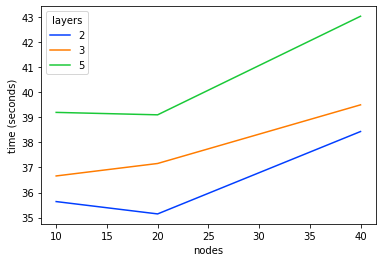

In [52]:
sns.color_palette("bright")
sns.lineplot(data =score2_df, x='nodes', y= 'time (seconds)', hue='layers', palette= sns.color_palette('bright', 3))


<AxesSubplot:xlabel='nodes', ylabel='Kaggle Score'>

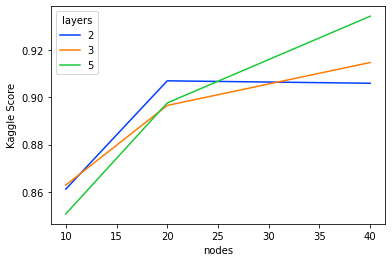

In [53]:
sns.lineplot(data =score2_df, x='nodes', y= 'Kaggle Score', hue='layers',  palette= sns.color_palette('bright', 3))

<AxesSubplot:xlabel='nodes', ylabel='training accuracy'>

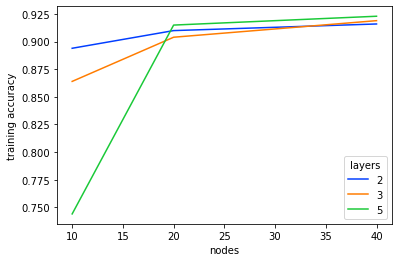

In [54]:
sns.lineplot(data =score2_df, x='nodes', y= 'training accuracy', hue='layers', palette= sns.color_palette('bright', 3))

%reload_ext tensorboard
%tensorboard --logdir='C:/Users/bblank/Documents/keras_logfiles' --host localhost port=6006

%reload_ext tensorboard

%tensorboard --logdir --port6006

In [55]:
###### code for hyperparameter tunring

#def model_builder(hp):
#  model = keras.Sequential()
#  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
#  hp_units = hp.Int('units', min_value=10, max_value=20, step=5)
#  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
#  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
#  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 3e-3, 5e-3])

#  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                metrics=['accuracy'])

#  return model


#tuner = kt.Hyperband(model_builder,
#                     objective='val_accuracy',
#                     max_epochs=10,
#                     factor=3,
#                     directory=logdir,
#                     project_name='intro_to_kt')
#                     
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)




#tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

#print(f"""
#The hyperparameter search is complete. The optimal number of units in the first densely-connected
#layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
#is {best_hps.get('learning_rate')}.""")


#best_hps.get('learning_rate')
#best_hps.get('units')

